# Zaliczenie programistyczne

Anton Hul, 308239

Radosław Suchowiecki, 305047

# Część 1. Rozwiązanie niezależnego od czasu równania Schrödingera

In [1]:
import sympy as sp
import numpy as np
sp.init_printing()
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import simps
import numba
from numba import jit
import threading
from scipy import sparse

# Definiowanie stałych fizycznych:
Uwzględniamy warunki brzegowe:

$$\psi(0)=0$$

Nie znamy wartości pochodnej $\psi'(0)$, a więc możemy przyjąć dowolną wartość np. 0.001, bo wartość ta wpływa tylko na skalę funckji:

In [24]:
N = 1000                         # liczba punktów   
psi = np.zeros([N,2])            # Funkcja falowa oraz jej pochodna
psi_0 = np.array([0,0.001])   # Warunki brzegowe
E = 0.0                          # Początkowa wartość energii 
inf = 2                         # Wybrany punkt w "nieskończoności", musi być znacznie większy od długości oscylatora
x = np.linspace(0, inf, N)       # oś x                 
m = 1                            # masa cząstki
w = 10                           # częstość drgań oscylatora
h = 1                            # stała Plancka 
L = 1                            # długość oscylatora

# Obszar 2
Równanie Schrödingera dla naszego zagadnienia jest w postaci:
$$ i \hbar \frac{\partial \Psi}{\partial t}=-\frac{\hbar^2}{2m} \frac{\partial^2 \Psi}{\partial x^2} + V(x)\Psi$$
$$ i \hbar \frac{\partial \Psi}{\partial t}=-\frac{\hbar^2}{2m} \frac{\partial^2 \Psi}{\partial x^2} + \frac{1}{2}m w_0^2 x^2\Psi$$
W przypadku stanów stacjonarnych szukamy rozwiązania powyższego równania w postaci:
$$ \Psi(x,t) = \psi(x)e^{-\frac{i E t}{\hbar}}$$
gdzie $\psi(x)$ spełnia równanie:

$$
E \psi(x)= -\frac{\hbar^2}{2m} \frac{\partial^2 \psi}{\partial x^2} + \frac{1}{2}m 
w_0^2 x^2\psi 
$$

Rozwiązujemy powyższe równanie za pomocą funckji odeint: 

Definiujemy funckje potencjału dla x > 0.

In [25]:
def V(x): 
    return 0.5*m*w**2*x**2

In [26]:
#definicja równania różniczkowego
def f(psi, x):
    s0 = psi[1]
    s1 = (2.0*m/h**2)*(V(x) - E)*psi[0]
    return np.array([s0, s1])

In [27]:
def Psi(energy):
    global psi
    global E
    E = energy
    #rozwiązujemy równanie (1) dla danej wartości E za pomocą funckji odeint,
    #uwzględniając warunki brzegowe
    psi = odeint(f, psi_0, x)
    #zwraca wartość funckji psi(x) w ostatnim punkcie
    return psi[-1,0]

Na tym etapie już mamy zależność  𝜓 (x) dla x > 0.

Szukamy możliwych stanów energetycznych.

Interesują nas tylko stany E, dla których  𝜙 (E) = 0 dla x  →   ∞ .

In [28]:
def E_values(x,y):
    E_zero = []
    s = np.sign(y)
    for i in range(len(y)-1):
        if s[i]+s[i+1] == 0:
            zero = optimize.brentq(Psi, x[i], x[i+1])
            E_zero.append(zero)
    return E_zero

Poszukujemy takich energii, dla których f($\infty$) = 0.

In [29]:
en = np.linspace(0, 70*h, 500)  
psi_end = []      
for e1 in en:
    psi_end.append(Psi(e1))           
E_zeroes = E_values(en, psi_end)   

Rysujemy możliwe stany energetyczne.

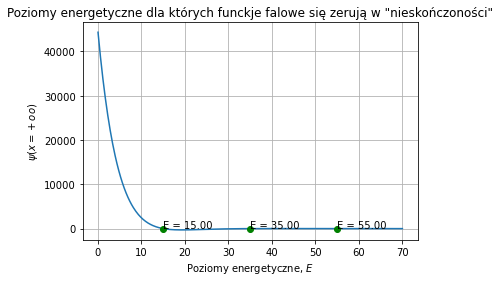

In [30]:
plt.figure()
plt.plot(en,psi_end)
plt.title('Poziomy energetyczne dla których funckje falowe się zerują w "nieskończoności"')
plt.xlabel('Poziomy energetyczne, $E$')
plt.ylabel('$\psi(x = +oo)$')
for E in E_zeroes:
    plt.plot(E, [0], 'go')
    plt.annotate("E = %.2f" %E, xy = (E, 0), xytext=(E, 0.01))
plt.grid()

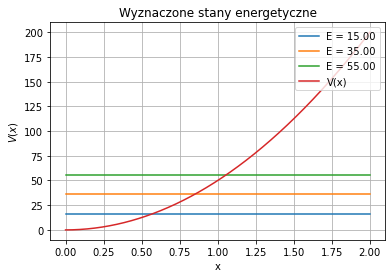

In [31]:
# Rysujemy wyznaczone stany energetyczne
plt.figure(2)
for i in range(len(E_zeroes)):   
    y = x**0 + E_zeroes[i]
    plt.plot(x, y, label="E = %.2f" %E_zeroes[i]) 
plt.plot(x, V(x), label="V(x)")     
plt.legend(loc="upper right")
plt.title('Wyznaczone stany energetyczne')
plt.xlabel('x')
plt.ylabel('$V(x)$')    
plt.grid() 

# Porównanie wartości teoretycznych z otrzymanymi wynikami 
Ogólnie poziomy energetyczne oscylatora harmonicznego wyrażają się wzorem:

$$ E_n = \hbar\omega(n+\frac{1}{2}) = \hbar\omega\frac{1}{2}(2n+1) $$
gdzie $n=0, 1, 2, 3, ...$

Jednak w naszym przypadku interesują nas tylko poziomy energetyczne, dla których funckje falowe spełniają podane warunki brzegowe:

$$ \phi(x=0)=0 $$

A więc podany wzór jest zgodny dla naszego przypadku tylko dla liczb n należących do liczb nieparzystych.
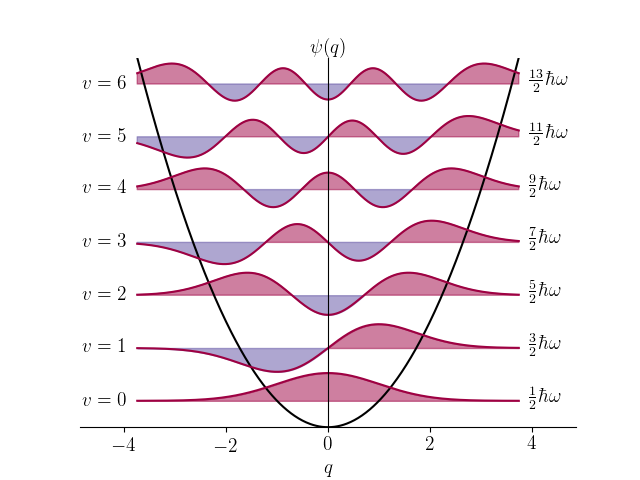

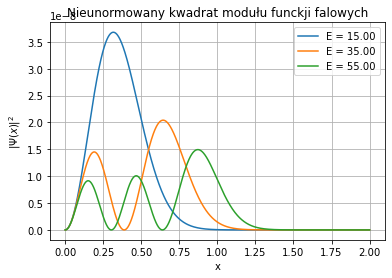

In [32]:
plt.figure(3)
for i in range(len(E_zeroes)):                                              
    Psi(E_zeroes[i])                                
    plt.plot(x, psi[:,0]**2, label="E = %.2f" %E_zeroes[i])     
plt.legend(loc="upper right")
plt.title('Nieunormowany kwadrat modułu funckji falowych')
plt.xlabel('x')
plt.ylabel('$|\Psi(x)|^2$')    
plt.grid()    

# Unormowanie
Normujemy powyższe funckje falowe całkując kwadrat modułu funckji na przedziale od $-\infty$ do $\infty$. Natomiast w przypadku rozwiązania numerycznego korzystamy z następującego algorytmu:

In [33]:
const = []
for i in range(len(E_zeroes)):                                              
    Psi(E_zeroes[i]) 
    const.append((1 / integrate.simps(psi[:,0]**2, x)))
#stałe normujące
cn = np.sqrt(const)

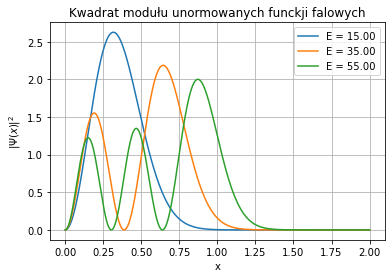

In [34]:
plt.figure(3)
for i in range(len(E_zeroes)):                                              
    Psi(E_zeroes[i])                                
    plt.plot(x, const[i]*psi[:,0]**2, label="E = %.2f" %E_zeroes[i]) 
    #print(integrate.simps(const[i]*psi[:,0]**2, x))
plt.legend(loc="upper right")
plt.title('Kwadrat modułu unormowanych funckji falowych')
plt.xlabel('x')
plt.ylabel('$|\Psi(x)|^2$')    
plt.grid() 

# Ewolucja funkcji falowych w czasie

In [35]:
def Psi_t(x, t, i):
    Psi(E_zeroes[i])           
    return cn[i]*psi[:,0]*np.exp(-complex(0,1)*E_zeroes[i]*t/h)

In [36]:
def PsiSum(x, t):
    Sum = 0
    N = np.sqrt(sum(cn**2))
    for i in range(len(E_zeroes)):
        Sum += cn[i]*Psi_t(x, t, i)
    return Sum / N

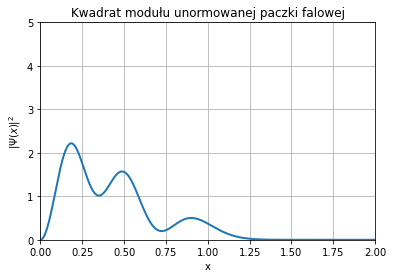

In [37]:
fig = plt.figure()
ax = plt.axes(xlim = (0, 2), ylim = (0, 5))
ax.set_title('Kwadrat modułu unormowanej paczki falowej')
ax.set_xlabel('x')
ax.set_ylabel('$|\Psi(x)|^2$')    
ax.grid() 

y_abs, = ax.plot([], [], lw = 2)

dt = 0.01

def animate_abs(i):
    y_abs.set_data(x, abs(PsiSum(x, i * dt))**2)
    return y_abs,

anim_abs = animation.FuncAnimation(fig, animate_abs, frames=100 , interval=50, blit=True)
HTML(anim_abs.to_html5_video())

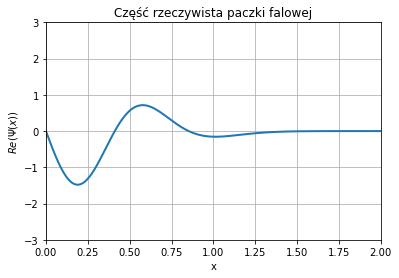

In [38]:
fig = plt.figure()
ax = plt.axes(xlim = (0, 2), ylim = (-3, 3))
ax.set_title('Część rzeczywista paczki falowej')
ax.set_xlabel('x')
ax.set_ylabel('$Re(\Psi(x))$')    
ax.grid() 

y_real, = ax.plot([], [], lw = 2)

def animate_real(i):
    y_real.set_data(x, np.real(PsiSum(x, i * dt)))
    return y_real,

anim_real = animation.FuncAnimation(fig, animate_real, frames=100 , interval=50, blit=True)
HTML(anim_real.to_html5_video())

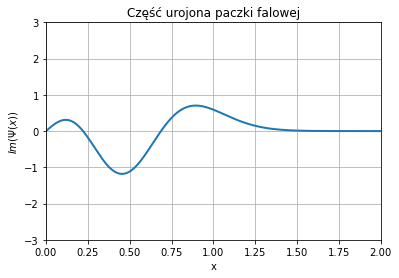

In [39]:
fig = plt.figure()
ax = plt.axes(xlim = (0, 2), ylim = (-3, 3))
ax.set_title('Część urojona paczki falowej')
ax.set_xlabel('x')
ax.set_ylabel('$Im(\Psi(x))$')    
ax.grid() 

y_imag, = ax.plot([], [], lw = 2)


def animate_imag(i):
    y_imag.set_data(x, np.imag(PsiSum(x, i * dt)))
    return y_imag,

anim_imag = animation.FuncAnimation(fig, animate_imag, frames=100, interval=50, blit=True)
HTML(anim_imag.to_html5_video())

# Część 2. Rozwiązanie zależnego od czasu równania Schrödingera

Spróbujemy rozwiązać początkowe równanie Schrödingera zależne od czasu:

$$ i \hbar \frac{\partial \Psi}{\partial t}=-\frac{\hbar^2}{2m} \frac{\partial^2 \Psi}{\partial x^2} + V(x)\Psi$$
$$ i \hbar \frac{\partial \Psi}{\partial t}=-\frac{\hbar^2}{2m} \frac{\partial^2 \Psi}{\partial x^2} + \frac{1}{2}m w_0^2 x^2\Psi$$

W tym celu skorzystamy z następującej zamiany drugiej pochodnej (tzw. the finite difference method with a
centered difference):
$$\frac{\partial^2 \Psi}{\partial x^2} = \frac{\Psi(x+\Delta x,t)-2\Psi(x,t)+\Psi(x-\Delta x, t)}{(\Delta x)^2} $$
Czyli po prostu zamieniając pochodną na kombinację liniową wartości funckji falowej w sąsiednich punktach. Powyższe wyrażenie możemy zastąpić również operatorem, zdefiniowanym w następujący sposób:
$$\textbf{J} \cdot \Psi =
\frac{1}{(\Delta x)^2}
\begin{pmatrix}
-2 & 1 & 0\\
1 & -2 & 1\\
0 & 1 & -2 
\end{pmatrix} 
\cdot
\begin{pmatrix}
\Psi(x+\Delta x,t)\\
\Psi(x,t)\\
\Psi(x-\Delta x,t)
\end{pmatrix} 
$$
Wtedy:
$$\frac{\partial^2 \Psi}{\partial x^2} = \textbf{J} \cdot \Psi $$
Wówczas początkowe równanie przyjmuje postać:
$$  i \hbar \frac{\partial \Psi}{\partial t} =-\frac{\hbar^2}{2m}  \frac{\Psi(x+\Delta x,t)-2\Psi(x,t)+\Psi(x-\Delta x, t)}{(\Delta x)^2}  + \frac{1}{2}m w_0^2 x^2\Psi$$
Skąd korzystając ze zdefiniowanego wcześniej operatora oraz przyjmując, że $\hbar=1$:

$$
\frac{\partial \Psi}{\partial t} = \frac{i}{2m} \textbf{J} \cdot \Psi - \frac{i}{2}m w_0^2 x^2\Psi \text{  } \text{  } \text{  } \text{ (1) } 
$$

Z powyższego równania wynika, że znając wartości funckji falowej w każdym punkcie dla dowolnej chwili czasu $t_0$ możemy znaleźć ewolucję funckji dla kolejnych chwil czasów $t$. Rozwiązujemy powyższe równanie za pomocą już zaimplementowanej funkcji integrate.solve_ivp, która przy zadanych warunkach początkowych $y(t_0) = y_0$ rozwiązuje równanie typu $\frac{dy}{dt} = f(t, y)$, czyli równanie (1).
   

In [40]:
dx    = 0.02          
sigma = 0.1                        
kx = 5

#stan początkowy (paczka gausowska)
psi0 = np.sqrt(1.0 / (sigma * np.sqrt(np.pi))) * np.exp(-(x-1)**2 / (2.0 * sigma**2)) * np.exp(1j * kx * x)       

Definiujemy operator $\textbf{J}$:

In [41]:
J = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / dx**2

In [42]:
J.toarray()*dx**2

array([[-2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -2.]])

In [43]:
def psi_t(t, psi):
    return 1j / (2*m) * J.dot(psi) - 1j*0.5*kx*x**2*psi

In [44]:
Dt = 0.05 
t0 = 0.0    
tk = 50.0    
t_eval = np.arange(t0, tk, Dt)
sol = integrate.solve_ivp(psi_t, t_span = [t0, tk], y0 = psi0, t_eval = t_eval, method="RK23")

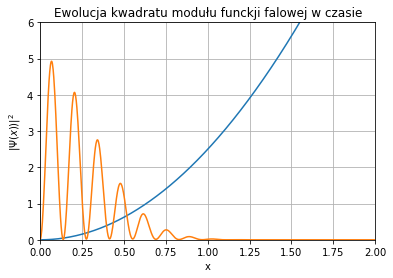

In [45]:
fig = plt.figure()
ax = plt.axes(xlim = (0, 2), ylim = (0, 6))
ax.set_title('Ewolucja kwadratu modułu funckji falowej w czasie')
ax.set_xlabel('x')
ax.set_ylabel('$|\Psi(x))|^2$')    
ax.grid() 

line_V, = ax.plot([], [])
line_f, = ax.plot([], [])

def init():
    line_V.set_data(x, 0.5*kx*x**2)
    return line_V,

def animate_t(i):
    line_f.set_data(x, np.abs(sol.y[:,i])**2)
    return line_f,


anim_t = animation.FuncAnimation(fig, animate_t, init_func=init,
                               frames=len(sol.t), interval=50, blit=True)
HTML(anim_t.to_html5_video())